# MIMO — Multi-Input Multi-Output Networks

### Introduction

In machine learning there are a few problems, one of them is confident misprediction. <br>
One solutions to tackle this problem are ensembles which use a base model multiple times to lower uncertainty for the prediction. <br>
There are different ways to use the output of the ensemble members but this topic is not part of this notebook. <br>
The problem with ensembles is there high cost because of training the members of the ensemble separately. One way to tackle this problem is to use MIMO (multi-input-multi-output) configuration. <br>
For further information: [Training independent subnetwroks for robust prediction](https://openreview.net/pdf?id=OGg9XnKxFAH)

### What is a MIMO ?

A MIMO uses mulitple inputs and outputs which can train subnetworks of the main network concurrently. By using this we get "free" forward passes while testing and leveraging the outputs similar to an ensemble. This method uses less computational cost and has the benefits of an ensemble.

### How to test performance ?

In the rest of the notebook is a short demo and comparison between a MIMO and an ensemble. Note, that this setup is not ideal. 

## 1. Quick Setup

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)  # oqa E702
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

## 2. Toy dataset (classification variant)

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=2000, noise=0.2, random_state=seed)
X = X.astype("float32")
y = y.astype("int64")

split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_ds), "Val size:", len(val_ds))

## 3. Baseline model (standard MLP)

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim: int = 2, hidden: int = 128, out_dim: int = 2) -> None:
        """MLP with two hidden layers."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Simple forward."""
        return self.net(x)


m = MLP().to(device)
print(m)

## 4. MIMO wrapper: make an M-input M-output version of the MLP



In [ ]:
class MIMO(nn.Module):
    def __init__(self, base_hidden: int = 128, in_dim: int = 2, out_dim: int = 2, M: int = 3) -> None:  # noqa: N803
        """MIMO model with M outputs."""
        super().__init__()
        self.M = M
        self.input_layer = nn.Linear(in_dim * M, base_hidden)
        self.body = nn.Sequential(
            nn.ReLU(),
            nn.Linear(base_hidden, base_hidden),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([nn.Linear(base_hidden, out_dim) for _ in range(M)])

    def forward(self, x_concat: torch.Tensor) -> torch.Tensor:
        """Forward pass with concatenated inputs."""
        h = self.input_layer(x_concat)
        h = self.body(h)
        outs = [head(h) for head in self.heads]
        outs = torch.stack(outs, dim=1)
        return outs


mimo_model = MIMO(M=3).to(device)
print(mimo_model)

## 5. Comparison between Ensemble and MIMO-Idea

Training an Ensemble and a MIMO to compare acc, loss, ece, MI(disagreement), forward calls.
The number of subnetworks is four as recommended in [TRAINING INDEPENDENT SUBNETWORKS FOR ROBUST
PREDICTION](https://openreview.net/pdf?id=OGg9XnKxFAH)


Setup:

K members in ensemble = 3

K subnetworks in the MIMO = 3 

Epochs = 250

lr = 1e-3



Epoch 10/250, Loss: 0.1108

Epoch 20/250, Loss: 0.1021

Epoch 30/250, Loss: 0.0515

Epoch 40/250, Loss: 0.0194

Epoch 50/250, Loss: 0.0468

Epoch 60/250, Loss: 0.1156

Epoch 70/250, Loss: 0.0359

Epoch 80/250, Loss: 0.1688

Epoch 90/250, Loss: 0.1418

Epoch 100/250, Loss: 0.0855

Epoch 110/250, Loss: 0.1077

Epoch 120/250, Loss: 0.0916

Epoch 130/250, Loss: 0.0502

Epoch 140/250, Loss: 0.0542

Epoch 150/250, Loss: 0.1192

Epoch 160/250, Loss: 0.1408

Epoch 170/250, Loss: 0.0584

Epoch 180/250, Loss: 0.0742

Epoch 190/250, Loss: 0.0372

Epoch 200/250, Loss: 0.0704

Epoch 210/250, Loss: 0.0930

Epoch 220/250, Loss: 0.1291

Epoch 230/250, Loss: 0.1138

Epoch 240/250, Loss: 0.0758

Epoch 250/250, Loss: 0.0182
MIMO total forward calls: 3250

Epoch 250/250, Loss: 0.0261

Epoch 250/250, Loss: 0.0138

Epoch 250/250, Loss: 0.0594
Ensemble total forward calls: 9750
MIMO — acc: 0.9725, nll: 0.0649, ece: 0.0085, MI(disagreement): 0.0005
Ensemble — acc: 0.9700, nll: 0.0629, ece: 0.0230, MI(disagre

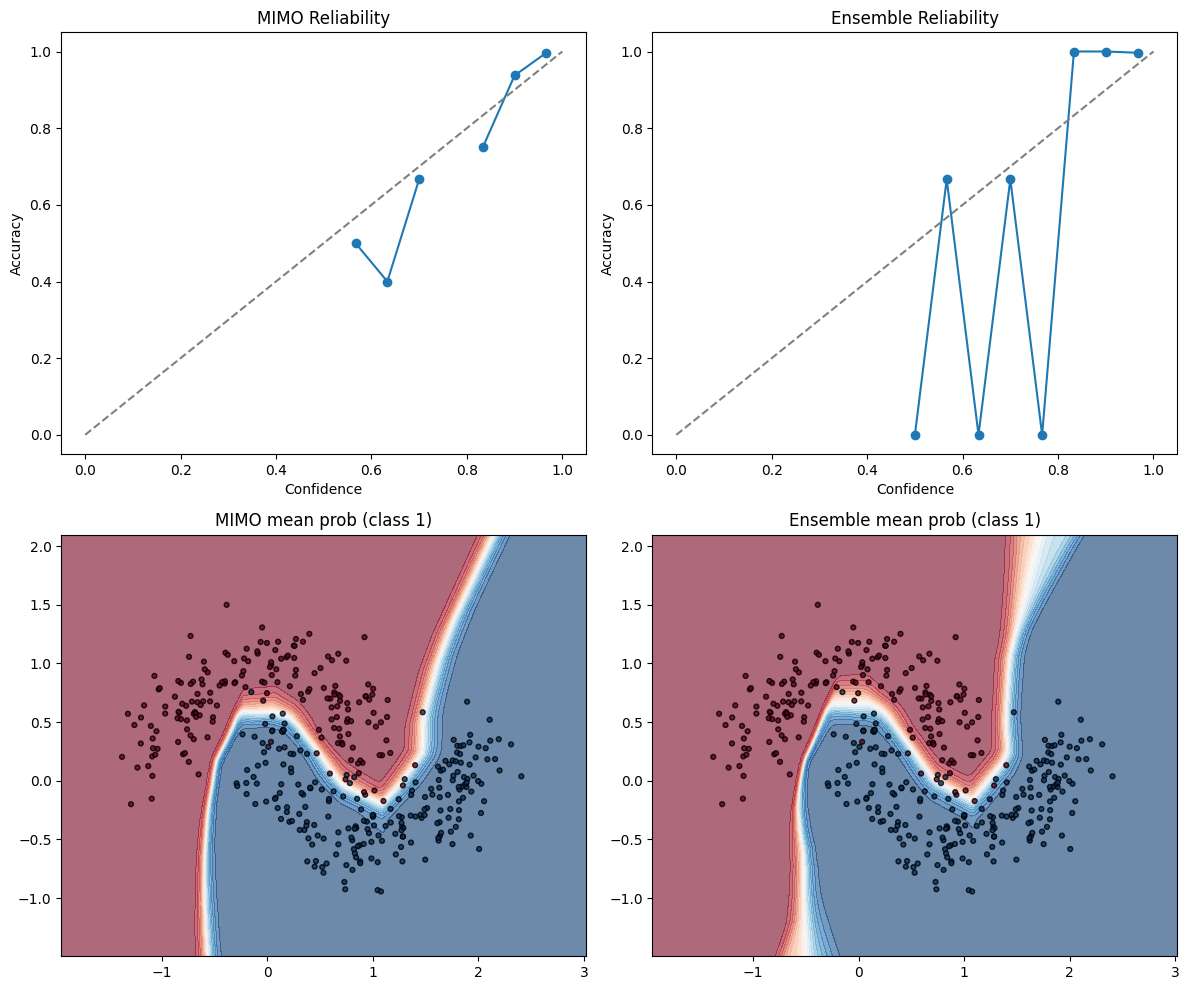

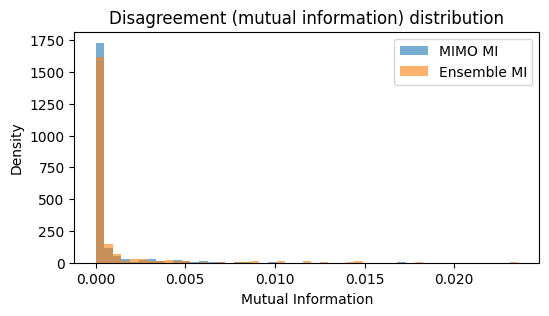

In [ ]:
# Small experiments: train MIMO and an ensemble with comparable capacity
K = 3
epochs = 250
lr = 1e-3


def softmax_np(logits: np.ndarray, axis: int = -1) -> np.ndarray:
    e = np.exp(logits - logits.max(axis=axis, keepdims=True))
    return e / e.sum(axis=axis, keepdims=True)


def entropy_np(probs: np.ndarray, axis: int = -1, eps: float = 1e-12) -> np.ndarray:
    p = np.clip(probs, eps, 1.0)
    return -np.sum(p * np.log(p), axis=axis)


def ece_score(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15) -> float:
    # probs: (N, C) predictive mean probs; labels: (N,)
    confs = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = len(labels)
    for i in range(n_bins):
        mask = (confs >= bins[i]) & (confs < bins[i + 1])
        if mask.sum() == 0:
            continue
        acc = (preds[mask] == labels[mask]).mean()
        conf = confs[mask].mean()
        ece += (mask.sum() / n) * abs(conf - acc)
    return float(ece)


def reliability_diagram(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15, ax: None = None) -> plt.Axes:
    confs = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    accs = []
    avg_confs = []
    counts = []
    for i in range(n_bins):
        mask = (confs >= bins[i]) & (confs < bins[i + 1])
        counts.append(mask.sum())
        if mask.sum() == 0:
            accs.append(np.nan)
            avg_confs.append(np.nan)
        else:
            accs.append((preds[mask] == labels[mask]).mean())
            avg_confs.append(confs[mask].mean())
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(bin_centers, accs, marker="o", label="accuracy per bin")
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title("Reliability diagram")
    return ax


# Train a normal ensemble of K independently initialized MLPs
def train_ensemble(base_cls: nn.Module, K: int, train_loader: DataLoader, epochs: int = 5, lr: float = 1e-3) -> list:  # noqa: N803
    models = []
    ensemble_forward_calls = 0
    for _ in range(K):
        m_k = base_cls().to(device)
        opt = optim.Adam(m_k.parameters(), lr=lr)
        lossfn = nn.CrossEntropyLoss()
        for epoch in range(epochs):  # noqa: B007
            m_k.train()
            for xb, yb in train_loader:
                x = xb.to(device).float()
                y = yb.to(device).long()
                opt.zero_grad()
                ensemble_forward_calls += 1
                out = m_k(x)
                loss = lossfn(out, y)
                loss.backward()
                opt.step()
        models.append(m_k)
        if (epoch + 1) % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    print(f"Ensemble total forward calls: {ensemble_forward_calls}")
    return models


def train_mimo(
    mimo_model: nn.Module,
    train_loader: DataLoader,
    epochs: int = epochs,
    lr: float = lr,
    m: int = K,
) -> nn.Module:
    opt = torch.optim.Adam(mimo_model.parameters(), lr=lr)
    lossfn = torch.nn.CrossEntropyLoss()
    forward_calls = 0  # Zähler

    for epoch in range(epochs):
        mimo_model.train()
        for xb, yb in train_loader:
            x = xb.to(device).float()
            y = yb.to(device).long()
            opt.zero_grad()

            forward_calls += 1
            xb_cat = x.repeat(1, m)
            out = mimo_model(xb_cat)

            # Mittelwert über die M Heads für Loss
            out_mean = out.view(out.size(0), m, -1).mean(dim=1)
            loss = lossfn(out_mean, y)
            loss.backward()
            opt.step()
        if (epoch + 1) % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    print(f"MIMO total forward calls: {forward_calls}")
    return mimo_model


# Evaluation helpers
def eval_ensemble_models(models: list, x_np: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # returns mean_probs (N, C), member_probs (N, K, C)
    x = torch.from_numpy(x_np).to(device).float()
    member_probs = []
    for m in models:
        m.eval()
        with torch.no_grad():
            logits = m(x).cpu().numpy()
            member_probs.append(softmax_np(logits))
    member_probs = np.stack(member_probs, axis=1)  # (N, K, C)
    mean_probs = member_probs.mean(axis=1)
    return mean_probs, member_probs


def eval_mimo_model(mimo_model: nn.Module, x_np: np.ndarray, m: int) -> tuple[np.ndarray, np.ndarray]:
    # For MIMO we feed the same input concatenated M times to get M heads' outputs
    x = torch.from_numpy(x_np).to(device).float()
    x_cat = x.repeat(1, m)  # (N, feat*M)
    mimo_model.eval()
    with torch.no_grad():
        logits = mimo_model(x_cat).cpu().numpy()  # (N, M, C)
    member_probs = softmax_np(logits, axis=-1)  # (N, M, C)
    mean_probs = member_probs.mean(axis=1)  # (N, C)
    return mean_probs, member_probs


# 1) (re)train mimo_model for fairness (short run)
mimo_model = MIMO(M=K).to(device)
train_mimo(mimo_model, train_loader, epochs=epochs, lr=lr, M=K)

# 2) train K independent MLPs
ensemble_models = train_ensemble(MLP, K, train_loader, epochs=epochs, lr=lr)

# Eval on validation set
X_val_np = X_val.astype("float32")
y_val_np = y_val.astype("int64")

mimo_mean, mimo_members = eval_mimo_model(mimo_model, X_val_np, M=K)
ens_mean, ens_members = eval_ensemble_models(ensemble_models, X_val_np)


# Metrics
def print_metrics(name: str, mean_probs: np.ndarray, member_probs: np.ndarray) -> None:
    acc = accuracy_score(y_val_np, mean_probs.argmax(axis=1))
    nll = log_loss(y_val_np, mean_probs)
    ece = ece_score(mean_probs, y_val_np, n_bins=15)
    # disagreement (mutual information proxy)
    h_mean = entropy_np(mean_probs)
    h_members = entropy_np(member_probs, axis=-1).mean(axis=1)
    mi = (h_mean - h_members).mean()
    print(f"{name} — acc: {acc:.4f}, nll: {nll:.4f}, ece: {ece:.4f}, MI(disagreement): {mi:.4f}")


print_metrics("MIMO", mimo_mean, mimo_members)
print_metrics("Ensemble", ens_mean, ens_members)

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Reliability diagrams
ax = axes[0, 0]
reliability_diagram(mimo_mean, y_val_np, n_bins=15, ax=ax)
ax.set_title("MIMO Reliability")
ax = axes[0, 1]
reliability_diagram(ens_mean, y_val_np, n_bins=15, ax=ax)
ax.set_title("Ensemble Reliability")

# 2) Decision boundary (mean-predictive probability for class 1)
ax = axes[1, 0]
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200),
)
grid = np.stack([xx.ravel(), yy.ravel()], axis=1).astype("float32")
mimo_grid_mean, _ = eval_mimo_model(mimo_model, grid, M=K)
ens_grid_mean, _ = eval_ensemble_models(ensemble_models, grid)
cs = ax.contourf(xx, yy, mimo_grid_mean[:, 1].reshape(xx.shape), levels=20, cmap="RdBu", alpha=0.6)
ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=12, cmap="RdBu", edgecolor="k", alpha=0.8)
ax.set_title("MIMO mean prob (class 1)")
ax = axes[1, 1]
cs = ax.contourf(xx, yy, ens_grid_mean[:, 1].reshape(xx.shape), levels=20, cmap="RdBu", alpha=0.6)
ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=12, cmap="RdBu", edgecolor="k", alpha=0.8)
ax.set_title("Ensemble mean prob (class 1)")

plt.tight_layout()
plt.show()

# Extra: plot disagreement histogram
plt.figure(figsize=(6, 3))
mimo_MI_per_example = entropy_np(mimo_mean) - entropy_np(mimo_members, axis=-1).mean(axis=1)  # noqa: N816
ens_MI_per_example = entropy_np(ens_mean) - entropy_np(ens_members, axis=-1).mean(axis=1)  # noqa: N816

max_val = max(float(np.nanmax(mimo_MI_per_example)), float(np.nanmax(ens_MI_per_example)))
bins = np.linspace(0.0, max_val, 50)

plt.hist(mimo_MI_per_example, bins=bins, density=True, alpha=0.6, label="MIMO MI", color="C0")
plt.hist(ens_MI_per_example, bins=bins, density=True, alpha=0.6, label="Ensemble MI", color="C1")

plt.legend()
plt.title("Disagreement (mutual information) distribution")
plt.xlabel("Mutual Information")
plt.ylabel("Density")
plt.show()

Comment: We see that MIMO has nearly 1/3 of the forward calls. Note, that the acc, nll, ece-score is nearly the same.